<b> Implementing Neural Network From Scratch </b>
<br />

In this notebook, we learn how to create a simple neural network and implement a basic neural network. Most of the codes and content are borrowed from Wildml.com [1] and is fully acknowledged.

In [1]:
#required imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
%matplotlib inline

Get the dataset from <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html"> sklearn </a>

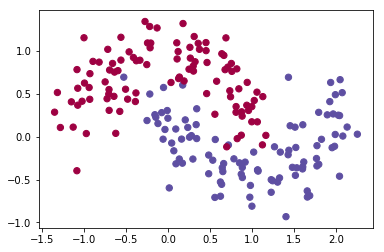

In [2]:
#we use sklearn to generate the toy data ()
# Generate a dataset and plot it
np.random.seed(0)
X, y = make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

The toy data consists of two classes - red and blue. If we consider the red
one as female patients and blue one as male patients, we can train
a machine learning classifier that predicts the correct class, given the x and y coordinates.
Note that the data is not linearly separable, we can’t draw a straight line that separates the two classes. 
This means that linear classifiers, such as Logistic Regression, won’t be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

In fact, that’s one of the major advantages of Neural Networks. You don’t need to worry about feature engineering. The hidden layer of a neural network will learn features for you.

Now, lets recap with some of the Machine Learning concepts before we create the actual neural network model.

<b> Logistic Regression </b>
<br/>

To demonstrate the point let’s train a Logistic Regression classifier. It’s input will be the x- and y-values and the output the predicted class (0 or 1). To make our life easy we use the Logistic Regression class from scikit-learn.

In [3]:
#lets create a utility method to plot the decision boundary
def plot_decision_boundary(pred_func, X, y, plotTitle="Logistic Regression"):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.02
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #print(Z.shape) #(328, 461)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title(plotTitle)
    #plt.show()

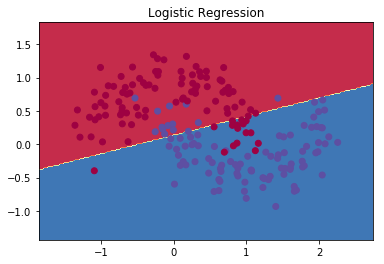

In [4]:
# Train the logistic rgeression classifier
#import the cross validation-based logistic regression
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()
clf.fit(X, y)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x), X, y, "Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it’s unable to capture the “moon shape” of our data.

<br/>
<b> A simple neural network </b>
<br/>
Let’s now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 (“female”) and one for class 1 (“male”). It looks something like this:
<img src ="images/nn-from-scratch-3-layer-network-1024x693.png"/>

<br/>
We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data.

<br/>
How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science.

<br/>
We also need to pick an activation function for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are tanh, the sigmoid function, or ReLUs.

<br/>
We will use tanh, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of $ tanhx $  is $1-tanh^2 x$. This is useful because it allows us to compute $tanh x$  once and re-use its value later on to get the derivative.

<br/>
Because we want our network to output probabilities the activation function for the output layer will be the softmax, which is simply a way to convert raw scores to probabilities.

<br/>
<b> Making Predictions using the Network </b>
<br/>
Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If x is the 2-dimensional input to our network then we calculate our prediction $ \hat{y} $ (also two-dimensional) as follows:
<br/>
$ z_1 = xW_1 + b_1 $
<br/>
$ a_1 = tanh(z_1) $
<br/>
$ z_2 = a_1W_2 + b_2 $
<br/>
$ a_2 = \hat{y} = softmax(z_2) $
<br/>
$z_i$ is the input of layer i and $a_i$ is the output of layer i after applying the activation function. $W_1$, $b_1$, $W_2$, $b_2$ are parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

<b> Paramter Learning </b>
<br/>
Learning the parameters for our network means finding parameters (W_1, b_1, W_2, b_2) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the loss function. A common choice with the softmax output is the categorical cross-entropy loss (also known as negative log likelihood). If we have N training examples and C classes then the loss for our prediction \hat{y} with respect to the true labels y is given by:

\begin{aligned}  L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}  \end{aligned} 
<br/>
We can use <a href= "http://cs231n.github.io/optimization-1/" > gradient descent </a> to find the minimum and I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you’ll want to use one of these, and ideally you would also <a href = "http://cs231n.github.io/neural-networks-3/#anneal"> decay the learning rate over time </a>.
<br/>
As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}, \frac{\partial{L}}{\partial{b_1}}, \frac{\partial{L}}{\partial{W_2}}, \frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the famous backpropagation algorithm, which is a way to efficiently calculate the gradients starting from the output. I won’t go into detail how backpropagation works, but there are many excellent explanations (<a href="http://colah.github.io/posts/2015-08-Backprop/"> here</a> or <a href="http://cs231n.github.io/optimization-2/"> here</a>) floating around the web.
<br/>
Applying the backpropagation formula we find the following (trust me on this):
<br/>
<img src = "images/backpropagation.png">
<br/>
<b> Implementation of Network </b>
<br/>
Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [5]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
 
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let’s implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [6]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    #the parameters are taken from the model object
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    
    #first hidden layer takes the original input, and processess it with 
    #  the parameters of this layer to get the input for next layer
    z1 = X.dot(W1) + b1
    #the output produced by the prvious layer is operated with an activation
    # function to make it ready as an input to the next layer
    a1 = np.tanh(z1)
    #the next hidden layer takes the output (which went through an activation function) from previous layer
    z2 = a1.dot(W2) + b2
    #now we find the softmax of the output from our finaly layer
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    #the above two lines can be replaced by
    # probs = np.exp(z2)/(np.sum(np.exp(z2)))
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [7]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
        
        #using tanh
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
         
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
     
    return model

<b> A NETWORK WITH A HIDDEN LAYER OF SIZE 3 </b>
<br/>
Let’s see what happens if we train a network with a hidden layer size of 3.

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069541
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


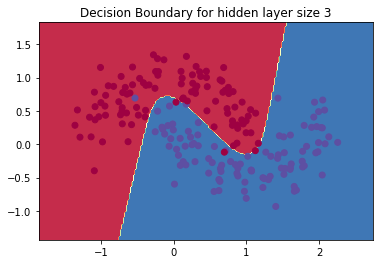

In [9]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X, y, plotTitle="Decision Boundary for hidden layer size 3")
#plt.title("Decision Boundary for hidden layer size 3")

Our neural networks was able to find a decision boundary that successfully separates the classes. If we look into the plot of the Logistic Regression, it was not clearly separating the two classes.

<br/>
<b> Chaning the Hidden Layers size </b>
<br/>
n the example above we picked a hidden layer size of 3. Let’s now get a sense of how varying the hidden layer size affects the result.


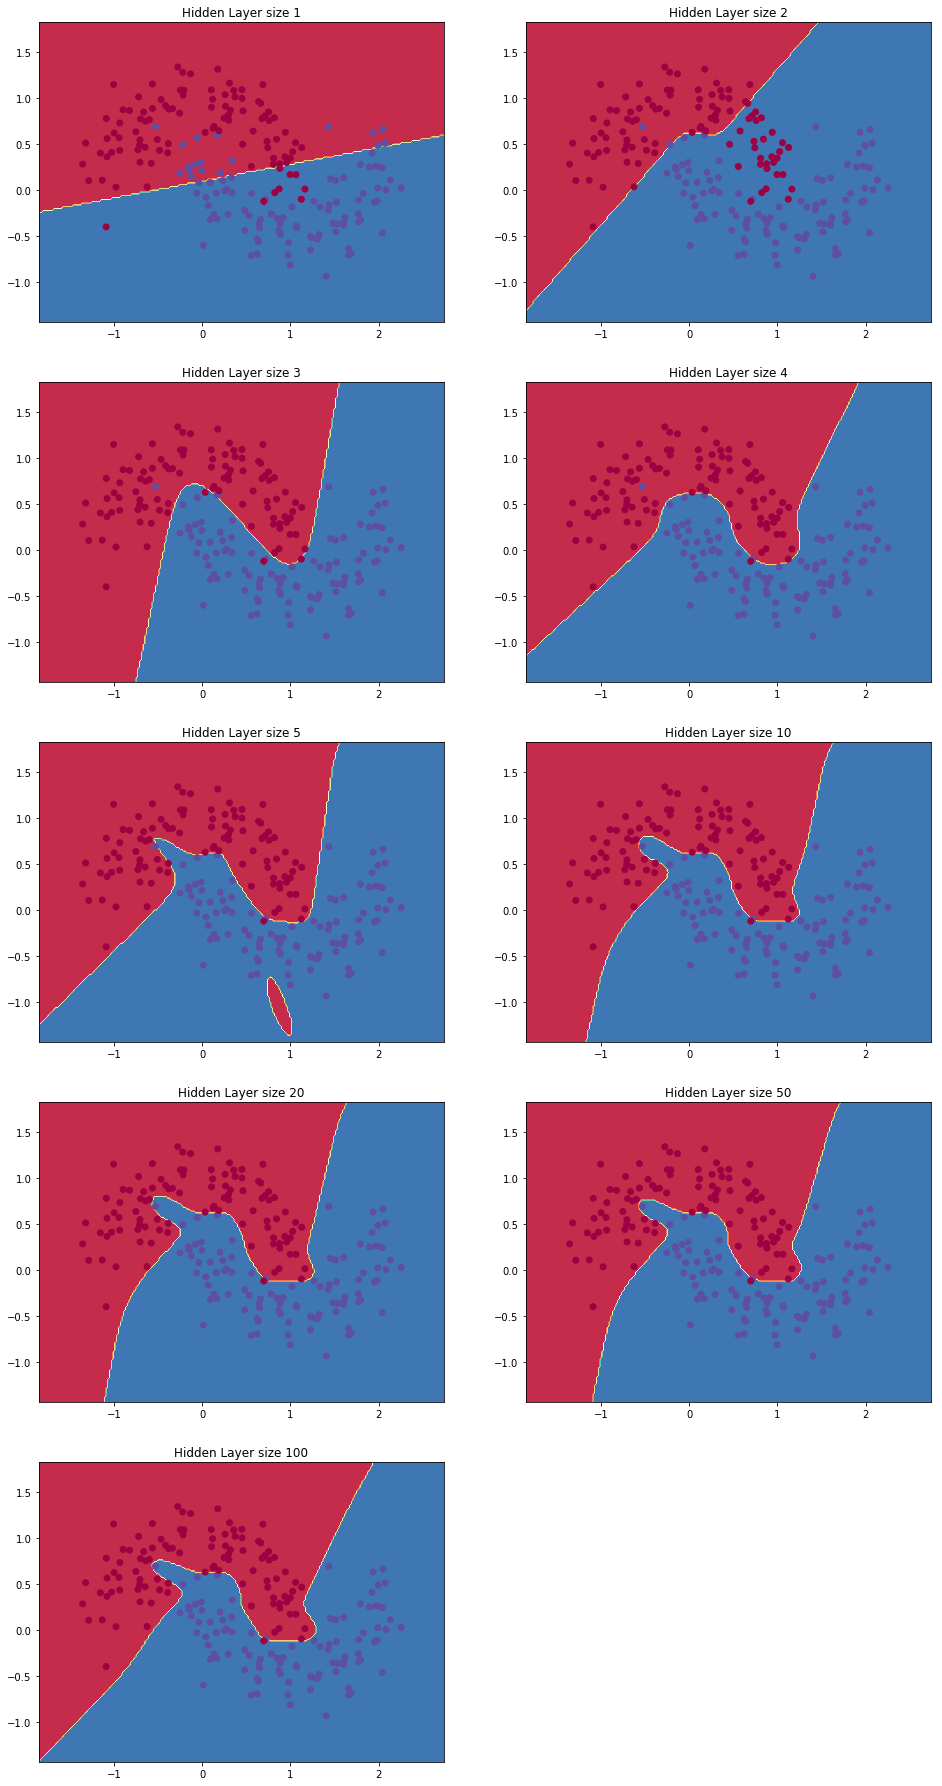

In [11]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 100]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    title = 'Hidden Layer size %d' % nn_hdim
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x), X, y,title)
#plt.show()

We can see that a hidden layer of low dimensionality nicely captures the general trend of our data. 
Higher dimensionalities are prone to overfitting. They are “memorizing” the data as opposed to fitting 
the general shape. If we were to evaluate our model on a separate test set (and you should!) the model 
with a smaller hidden layer size would likely perform better due to better generalization. We could 
counteract overfitting with stronger regularization, but picking the a correct size for hidden layer 
is a much more “economical” solution.

<br/>
<b>EXERCISES</b>

Here are some things you can try to become more familiar with the code:
<ol>
<li> Instead of batch gradient descent, use minibatch gradient descent (<a href="http://cs231n.github.io/optimization-1/#gd"> more info</a>) to train the network. Minibatch gradient descent typically performs better in practice.

<li> We used a fixed learning rate \epsilon for gradient descent. Implement an annealing schedule for the gradient descent learning rate (<a href="http://cs231n.github.io/neural-networks-3/#anneal">more info</a>).

<li> We used a \tanh activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.

<li> Extend the network from two to three classes. You will need to generate an appropriate dataset for this.

<li> Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.
</ol>

<b> Enhancement with ReLU </b>
enhancements with ReLU can be done by using the following replacement in the build_model method
using ReLU the function can be 

a1[a1<0] = 0

where as using tanh it was

a1 = np.tanh(z1)

We used max function for ReLU but there are other options (like multiplication) which can be used.

<b> Enhancement with Sigmoid </b>

This can be simply defined using a sigmoid function as:

a1 = 1/(1+ np.exp(-b))




<b> References </b>
<ol>
<li> http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/ </li>
</ol>